# Create Labels

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
gdf = gpd.read_file("/home/nus/workspace/datasets/mangroves/gmw_v3_2020_vec/gmw_v3_2020_vec.shp")

print(gdf.head())         # See first few rows
print(gdf.columns)        # List all attribute columns
print(gdf.crs)            # Coordinate Reference System
print(gdf.shape)          # Number of features (rows) and columns

   PXLVAL                                           geometry
0       1  POLYGON ((172.05689 6.01844, 172.05711 6.01844...
1       1  POLYGON ((172.05689 6.01711, 172.05711 6.01711...
2       1  POLYGON ((172.05511 6.01622, 172.05644 6.01622...
3       1  POLYGON ((172.06178 6.01333, 172.062 6.01333, ...
4       1  POLYGON ((172.06289 6.01333, 172.06311 6.01333...
Index(['PXLVAL', 'geometry'], dtype='object')
EPSG:4326
(1076117, 2)


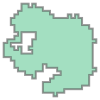

In [22]:
gdf.iloc[-1].geometry

In [23]:
import rasterio
from rasterio.features import geometry_mask
import numpy as np
from shapely.ops import transform as shp_transform
import pyproj
from rasterio.features import rasterize


def ratio_pixels_inside(geom, target_crs_epsg=3857, pixel_size=10.0, padding=0.0, all_touched=False):
    """
    Compute ratio of pixels inside a geometry over total pixels in the bounding grid.

    Parameters
    - geom: shapely geometry (in its current CRS, typically EPSG:4326)
    - target_crs_epsg: EPSG code of projected CRS to rasterize in (e.g., 3857 or a UTM zone)
    - pixel_size: pixel size in units of target CRS (meters for most projected CRSs)
    - padding: extra margin added around the geometry bounds (in target CRS units)
    - all_touched: if True, any pixel touched by geometry counts as inside; if False, uses pixel centers

    Returns
    - inside_count: number of pixels flagged inside
    - total_count: total pixels in the grid
    - ratio: inside_count / total_count
    """
    # 1) Reproject geometry to target CRS
    source_crs = "EPSG:4326"  # adjust if your geom is not in lat/lon
    target_crs = f"EPSG:{target_crs_epsg}"
    project = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True).transform
    geom_proj = shp_transform(project, geom)

    # 2) Determine grid bounds in target CRS
    minx, miny, maxx, maxy = geom_proj.bounds
    minx -= padding
    miny -= padding
    maxx += padding
    maxy += padding

    # 3) Compute raster width/height
    width = int(np.ceil((maxx - minx) / pixel_size))
    height = int(np.ceil((maxy - miny) / pixel_size))
    if width <= 0 or height <= 0:
        raise ValueError("Computed raster dimensions are non-positive. Check bounds and pixel_size.")

    # 4) Build affine transform (upper-left origin)
    transform = rasterio.transform.from_origin(minx, maxy, pixel_size, pixel_size)
    # Note: from_origin(x_left, y_top, x_res, y_res)

    # 5) Rasterize geometry to a boolean mask
    mask = rasterize(
        [(geom_proj, 1)],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        all_touched=all_touched,
        dtype=np.uint8
    )

    inside_count = int(mask.sum())
    total_count = int(width * height)
    ratio = inside_count / total_count if total_count > 0 else 0.0
    return inside_count, total_count, ratio, mask

(18, 18) 156 324 0.48148148148148145


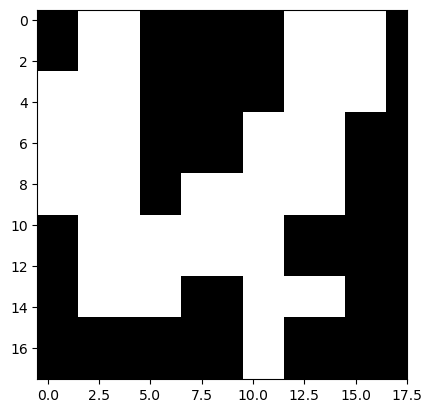

In [37]:
geom = gdf.iloc[-3].geometry
inside_count, total_count, ratio, mask = ratio_pixels_inside(geom)

print(mask.shape, inside_count, total_count, ratio)
plt.imshow(mask, cmap='gray')

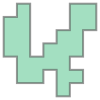

In [38]:
geom